In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from matplotlib import cm
from mpl_toolkits import mplot3d

In [26]:
A_w = 2
B_w = 2
K = 100
N = 12 # Number of coin flips
Z = 9  # Number of heads
GRANULARITY = 100

$p(\theta, \omega) = p(\theta|\omega)p(\omega)$

In [3]:
theta = np.linspace(0, 1, GRANULARITY)
omega = np.linspace(0, 1, GRANULARITY)
THETA, OMEGA = np.meshgrid(theta, omega)
prior = np.multiply(beta.pdf(THETA, OMEGA * (K - 2) + 1, (1 - OMEGA) * (K - 2) + 1), beta.pdf(OMEGA, A_w, B_w))
marginal_theta = np.sum(prior, axis = 1) / prior.shape[0]
marginal_omega = np.sum(prior, axis = 0)

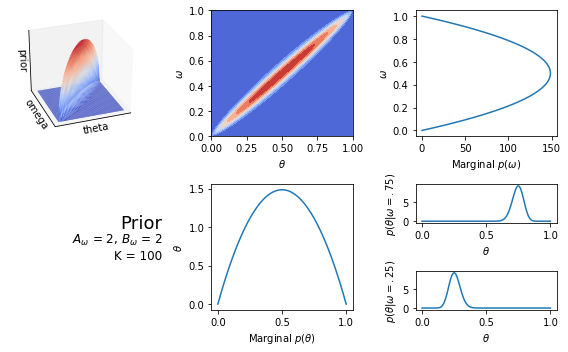

In [72]:
fig = plt.figure(constrained_layout = False)
gs = fig.add_gridspec(4, 3)
ax1 = fig.add_subplot(gs[0:2, 0], projection='3d')
ax1.plot_surface(THETA, OMEGA, prior, cmap = cm.coolwarm, edgecolor = 'none')
ax1.view_init(30, 250)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.xaxis.labelpad = -15
ax1.yaxis.labelpad = -15
ax1.zaxis.labelpad = -15
ax1.set_xlabel('theta')
ax1.set_ylabel('omega')
ax1.set_zlabel('prior')

ax2 = fig.add_subplot(gs[0:2, 1])
ax2.contourf(THETA, OMEGA, prior, cmap = cm.coolwarm)
ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel(r'$\omega$')
 
ax3 = fig.add_subplot(gs[0:2, 2])
ax3.plot(marginal_omega, omega)
ax3.set_xlabel(r'Marginal $p(\omega)$')
ax3.set_ylabel(r'$\omega$')

ax4 = fig.add_subplot(gs[2:4, 0])
ax4.axis('off')
parameters_str = '$A_{\omega}$ = ' + str(A_w) + ', $B_{\omega}$ = ' + str(B_w) + '\nK = ' + str(K)
ax4.text(1.1, 0.65, 'Prior', transform = ax4.transAxes, fontsize = 18, horizontalalignment = 'right')
ax4.text(1.1, 0.4, parameters_str, transform = ax4.transAxes, fontsize = 12, horizontalalignment = 'right')

ax5 = fig.add_subplot(gs[2:4, 1])
ax5.plot(theta, marginal_theta)
ax5.set_ylabel(r'$\theta$')
ax5.set_xlabel(r'Marginal $p(\theta)$')

ax6 = fig.add_subplot(gs[2, 2])
ax6.plot(theta, beta.pdf(theta, 0.75 * (K - 2) + 1, (1 - 0.75) * (K - 2) + 1))
ax6.set_xlabel(r'$\theta$')
ax6.set_ylabel(r'$p(\theta|\omega=.75)$')

ax7 = fig.add_subplot(gs[3, 2])
ax7.plot(theta, beta.pdf(theta, 0.25 * (K - 2) + 1, (1 - 0.25) * (K - 2) + 1))
ax7.set_xlabel(r'$\theta$')
ax7.set_ylabel(r'$p(\theta|\omega=.25)$')

fig.set_figwidth(8)
fig.set_figheight(5)
plt.tight_layout()

$p(D|\theta, \omega) = \theta^{z}(1 - \theta)^{n-z}$

In [29]:
likelihood = np.multiply(np.power(THETA, Z), np.power(1 - THETA, N - Z))

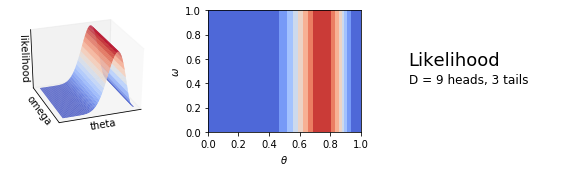

In [73]:
fig = plt.figure(constrained_layout = False)
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[:, 0], projection='3d')
ax1.plot_surface(THETA, OMEGA, likelihood, cmap = cm.coolwarm, edgecolor = 'none')
ax1.view_init(30, 250)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.xaxis.labelpad = -15
ax1.yaxis.labelpad = -15
ax1.zaxis.labelpad = -15
ax1.set_xlabel('theta')
ax1.set_ylabel('omega')
ax1.set_zlabel('likelihood')

ax2 = fig.add_subplot(gs[:, 1])
ax2.contourf(THETA, OMEGA, likelihood, cmap = cm.coolwarm)
ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel(r'$\omega$')

ax3 = fig.add_subplot(gs[:, 2])
ax3.axis('off')
data_str = 'D = ' + str(Z) + ' heads, ' + str(N - Z) + ' tails'
ax3.text(0, 0.55, 'Likelihood', transform = ax3.transAxes, fontsize = 18, horizontalalignment = 'left')
ax3.text(0, 0.4, data_str, transform = ax3.transAxes, fontsize = 12, horizontalalignment = 'left')


fig.set_figwidth(8)
fig.set_figheight(2.5)
plt.tight_layout()